# The Problem

In this notebook, we implement a DQN agent to navigate a square world and collect yellow banas as reward.  

**state**: conitunous, size=37  
**action**: discrete, size=4  
**reward**: +1 for yellow bananas, -1 for blue bananas  
**task**: episodic, and is considered as solved, when the mean score over 100 episodes reaches 13

When interacting with the environment, the agent
- observe the current state $S_t$, 
- make an action $A_t$, 
- collection the reward $R_{t+1}$, 
- observe the next state $S_{t+1}$ and get a boolean `done` indicating whether it is the end of the episode. 

From the experience, the agent should learn a good approximation of the action value function $Q(S_t; A_t)$. 


# The Solution

## Neural Network  

In this implementation, we use a neural network with two hidden layers, to estimate the action values for a state.

```
nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_size))

```

## Loss Function

Naturally, we would want to minimize the MSE, 

$J(\theta) = [ Q(S_t, A_t) - \hat{Q}(S_t, A_t, \theta) ]^2$,

by updating the weights with the negative gradient of the loss function,

$\theta \to \theta - \alpha \nabla_{\theta} J(\theta)$


But the true action value function $Q(S_t; A_t)$ is unknown, so we will use **TD-error** instead, where the true action value function is replaced with the **fixed Q-target**,  

$J(\theta) = [ (R_{t+1} + \gamma * \max_{a}\hat{Q}_{target}(S_{t+1}, a; \theta')) * (1- \text{done}) - \hat{Q}(S_t, A_t; \theta) ]^2$ 

- The weight $\theta'$ is mantained in a separate "target" neural network (of the same architecture as the "predictor" network)
- We feed a batch of $(S_t, A_t, R_{t+1}, S_{t+1}, \text{done})$ through the two networks. Calculate the TD-error, and update the weight of the predictor network, $\theta$ accordingly.
- Note that the operation on the target network should be in `.detach()` mode, since we don't need gradient from it. The weight of the target network, $\theta'$ is soft updated with the weight of the predictor network, $\theta$, every few steps: $\theta' \to (1-\tau)\theta'+\theta$  


## Replay Buffer

The current and next state are highly correlated. With online learning, we could be reinforcing over a not so ideal actions or get stuck in a state. 

To stablize training, we separate out learning and playing. 

While playing, the agent stores the experience in a buffer (a `deque`, that holds the most recent `n` experience tuples). After a few playing steps, the agent performs one learning step by sampling a small batch of experience tuples uniformly, feed them through the neural networks, and then update the weight of the predictor and the target network. 

## Agent

As described above, the agent has two functions

- to play
    - sample an action using epsilon-greedy with decay after each episode
    - save the playing experience in the replay buffer
- and to learn
    - sample the past experiences in the replay buffer
    - update the neural networks weights to minimize TD-error

## Psuedo-code

Let's combine every pieces together:


```
for each episode:

    reset the environment and observe starting state S_t
    decay the epsilon -> max(epsilon * epsilon_decay, min_epsilon)
    
    while the episode has not end:
    
        - agent samples an action using Q(S_t, a \in A(S_t)) epsilon-greedily
        - env steps on the chosen action, and returns next_state, reward, done
        - agent saves (state, action, next_state, reward, done) tuple to buffer

        every other x time step:
        
            - agent sampels a batch of experience tuple
            - agent feeds the experience to NNs, calculate the loss, update the weights
                
```


# The Implementation

Now that we have covered the learning algorithm, we can finally start implementing!

At the bottom of this notebook, you can watch my trained agent going bananas at yellow bananas ;)

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
env = UnityEnvironment(
    file_name="/Users/zinanj/projects/udacity/drlnd/deep-reinforcement-learning/p1_navigation/Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
env_info = env.reset(train_mode=True)[brain_name]
print(f'numer of agents: {len(env_info.agents)}')
action_size = brain.vector_action_space_size
print(f'action space: {action_size}')

state = env_info.vector_observations[0]
state_size = len(state)
print(f'state size: {state_size}')
print(f'a sample state: {state}')

numer of agents: 1
action space: 4
state size: 37
a sample state: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]


In [6]:
import torch
import torch.nn as nn
import numpy as np

In [7]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [8]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_size)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [9]:
from collections import namedtuple, deque
import random

class ReplayBuffer():
    def __init__(self, buffer_size, sample_size):
        self.buffer = deque(maxlen=buffer_size)
        self.sample_size = sample_size
        self.experience_factory = namedtuple(
            'experience', ['state', 'action', 'reward', 'next_state', 'done'])
    
    def add(self, state, action, reward, next_state, done):
        experience = self.experience_factory(
            state, action, reward, next_state, done)
        self.buffer.append(experience)
    
    def sample(self):
        if len(self.buffer) < self.sample_size:
            raise Exception('sample size is larger than buffer size')
            
        experiences = random.sample(self.buffer, self.sample_size)
        
        states = torch.from_numpy(
            np.vstack([e.state for e in experiences])).float().to(device)
        actions = torch.from_numpy(
            np.vstack([e.action for e in experiences])).long().to(device)
        rewards = torch.from_numpy(
            np.vstack([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(
            np.vstack([e.next_state for e in experiences])).float().to(device)
        dones = torch.from_numpy(
            np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(device)
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)
    
    def __repr__(self):
        return str(self.buffer)

In [10]:
BUFFER_SIZE = int(1e5)
SAMPLE_SIZE = 64
LR = 5e-4
GAMMA = 0.99
TAU = 1e-3
UPDATE_EVERY = 4

In [11]:
import torch.nn.functional as F
import torch.optim as optim

In [12]:
class Agent():
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.buffer = ReplayBuffer(BUFFER_SIZE, SAMPLE_SIZE)
        
        self.q_pred_network = QNetwork(state_size, action_size).to(device)
        self.q_target_network = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_pred_network.parameters(), lr=LR)
        
        self.t_step = 0
    
    def sample(self, state, eps):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        if np.random.uniform(0, 1) > eps:
            self.q_pred_network.eval()
            with torch.no_grad():
                action_values = self.q_pred_network(state)
            self.q_pred_network.train()
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return np.random.choice(np.arange(action_size))
    
    def step(self, state, action, reward, next_state, done):
        self.buffer.add(state, action, reward, next_state, done)
        
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.buffer) > SAMPLE_SIZE:
                experiences = self.buffer.sample()
                self.learn(experiences, GAMMA) 
         
    def learn(self, experiences, gamma):        
        states, actions, rewards, next_states, dones = experiences
        
        # Q_{target}(S_t,A_t) = r + \gamma * max_{a', a' \in A(S_{t+1})}Q(S_{t+1}, a') * (1 - done)
        Q_next_states = self.q_target_network(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_next_states * (1 - dones))
        
        # Q_{pred}(S_t, A_t)
        Q_preds = self.q_pred_network(states).gather(1, actions)
        
        # Minimize the MSE of action-values
        loss = F.mse_loss(Q_preds, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.soft_update(self.q_pred_network, self.q_target_network, TAU)
    
    def soft_update(self, pred_network, target_network, tau):
        for pred_param, target_param in zip(
            pred_network.parameters(), target_network.parameters()):
            target_param.data.copy_(
                (1.0 - tau) * target_param.data + tau * pred_param.data)


In [13]:
agent = Agent(state_size, action_size)

In [18]:
WINDOW = 100

In [19]:
def run(n_episodes=2000, max_t=300, max_eps=1.0, min_eps=0.01, eps_decay=0.995):
    scores = []
    scores_window = deque(maxlen=WINDOW)
    eps = max_eps
    
    for i in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name] 
        state = env_info.vector_observations[0]
        score = 0
        
        for j in range(max_t):
            action = agent.sample(state, eps)
            
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]                   
            done = env_info.local_done[0]  
            
            agent.step(state, action, reward, next_state, done)
            
            score += reward   
            state = next_state 
            
            if done:
                break
        
        scores.append(score)
        scores_window.append(score)
        eps = max(eps * eps_decay, min_eps)
        print(f"\rEpisode: {i}, Average Score: {np.mean(scores_window)}", end="")
        
        if i % WINDOW == 0:
            print(f"\rEpisode: {i}, Average Score: {np.mean(scores_window)}")
        
        if np.mean(scores_window) >= 13.:
            print(f"\rEnvironment solved in {i-100} episodes, Average Score {np.mean(scores_window)}")
            torch.save(agent.q_pred_network.state_dict(), 'checkpoint.pth')
            break
            
    return scores

scores = run()

Episode: 100, Average Score: 0.541515151515151546
Episode: 200, Average Score: 4.65
Episode: 300, Average Score: 7.99
Episode: 400, Average Score: 10.48
Episode: 500, Average Score: 12.74
Environment solved in 408 episodes, Average Score 13.01


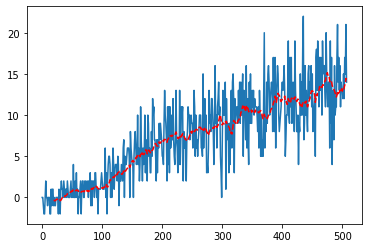

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots()
ax.plot(scores)
ax.plot(pd.DataFrame(scores).rolling(20).mean(), color='r', linestyle='--');

Next we are going to load the saved trained weights and see how does the agent perform

In [42]:
agent = Agent(state_size, action_size)

agent.q_pred_network.load_state_dict(
    torch.load('checkpoint.pth'))

In [45]:
env_info = env.reset(train_mode=False)[brain_name] 
state = env_info.vector_observations[0]            
score = 0                                          
while True:
    action = agent.sample(state, 0)        
    env_info = env.step(action)[brain_name]        
    next_state = env_info.vector_observations[0]   
    reward = env_info.rewards[0]                   
    done = env_info.local_done[0]                  
    score += reward                                
    state = next_state                             
    if done:                                       
        break
    
print("Score: {}".format(score))

Score: 20.0


Not bad! You can see the agent in action in the youtube video below

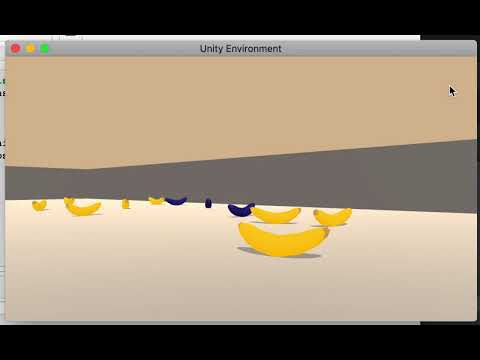

In [2]:
# https://youtu.be/IPRzAoFQXUc
from IPython.display import YouTubeVideo
YouTubeVideo('IPRzAoFQXUc')